In [1]:
import sys
import os
from time import time

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from skimage import measure
from scipy.optimize import linear_sum_assignment

sys.path.insert(0, os.path.abspath('..'))

from src.utils.load_cfg import ConfigLoader
from src.factories import ModelFactory
from src.factories import DatasetFactory
from src.utils.misc import MiscUtils
from src.models.pytorch_ssim.ssim import SSIM

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid', {'axes.grid': False})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_cfg = '../configs/dataset_cfgs/epickitchens_short.yaml'
train_cfg = '../configs/train_cfgs/train_san_freeze_short.yaml'
model_cfg = '../configs/model_cfgs/pipeline5_rgbspec_san19pairfreeze_actreggru3_top3_cat.yaml'

In [2]:
#--------------------------------------------------------------------------------------
# Load configurations
model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)
# model_params['num_segments'] = 5
dataset_name, dataset_params = ConfigLoader.load_dataset_cfg(dataset_cfg)
train_params = ConfigLoader.load_train_cfg(train_cfg)

dataset_params.update({
    'modality': model_params['modality'],
    'num_segments': model_params['num_segments'],
    'new_length': model_params['new_length'],
})

for k in ['low_feat_model_cfg', 'high_feat_model_cfg', 'actreg_model_cfg', 'spatial_sampler_cfg']:
    model_params[k] = '../'+model_params[k]

#--------------------------------------------------------------------------------------
# Build model
model_factory = ModelFactory()
model = model_factory.generate(model_name, device=device, model_factory=model_factory, **model_params)
model = model.to(device)
# model.load_model(model_weight)
model.eval()

#--------------------------------------------------------------------------------------
# Get training augmentation and transforms
train_augmentation = MiscUtils.get_train_augmentation(model.modality, model.crop_size)
train_transform, val_transform = MiscUtils.get_train_val_transforms(
    modality=model.modality,
    input_mean=model.input_mean,
    input_std=model.input_std,
    scale_size=model.scale_size,
    crop_size=model.crop_size,
    train_augmentation=train_augmentation,
)

#--------------------------------------------------------------------------------------
# Data loader
dataset_factory = DatasetFactory()
loader_params = {
    'batch_size': train_params['batch_size'],
    'num_workers': train_params['num_workers'],
    'pin_memory': True,
}

val_dataset = dataset_factory.generate(dataset_name, mode='val', transform=val_transform, **dataset_params)
val_loader = DataLoader(val_dataset, shuffle=False, **loader_params)

In [3]:
def sample_frame(attn, img_size, reorder):
    if model.spatial_sampler.top_k == 0:
        return None

    assert attn.shape[-1] == attn.shape[-2]
    attn_size = attn.shape[-1]
    batch_size = attn.shape[0]
    if model.spatial_sampler._prev_bboxes is not None:
        assert len(model.spatial_sampler._prev_bboxes) == batch_size

    # Flatten the attention
    attn = attn.mean(dim=1)

    # For each sample in batch
    results = []
    all_masks = []
    for b in range(batch_size):
        # Get bboxes in attention plane
        props, top_segids = model.spatial_sampler._get_bbox_from_attn(
            attn[b].cpu().detach().numpy(), simple_return=True)

        # Project to image plane
        bboxes = []
        for sid in top_segids:
            top, left, bottom, right = model.spatial_sampler._project_image_plane(
                props[sid], attn_size=attn_size, img_size=img_size)
            bboxes.append([top, left, bottom, right])
        
        # get top masks
        mask = np.zeros([attn_size, attn_size])
        for ii, sid in enumerate(top_segids):
            mask[props[sid].coords[:, 0], props[sid].coords[:, 1]] = model.spatial_sampler.top_k - ii

        # Append the last item if not enough bboxes
        if len(bboxes) != model.spatial_sampler.top_k:
            bboxes += [bboxes[-1]] * (model.spatial_sampler.top_k - len(bboxes))

        # Reorder
        if reorder:
            if (model.spatial_sampler._prev_bboxes is not None) and (model.spatial_sampler._prev_bboxes[b] is not None):
                bboxes = model.spatial_sampler._sort_bboxes(model.spatial_sampler._prev_bboxes[b], bboxes)
            else:
                if model.spatial_sampler._prev_bboxes is None:
                    model.spatial_sampler._prev_bboxes = [None for _ in range(batch_size)]
                model.spatial_sampler._prev_bboxes[b] = bboxes

        # Collect results
        results.append(bboxes)
        all_masks.append(np.expand_dims(mask, axis=0))
    return np.array(results), np.array(all_masks)


def sample_multiple_frames(attns, img_size, reorder):
    if model.spatial_sampler.top_k == 0:
        return None

    n_frames = attns.shape[1]
    all_bboxes = []
    all_masks = []

    model.spatial_sampler.reset()
    for t in range(n_frames):
        bboxes, masks = sample_frame(attns[:, t], img_size, reorder)
        all_bboxes.append(np.expand_dims(bboxes, axis=1))
        all_masks.append(np.expand_dims(masks, axis=1))
    all_bboxes = np.concatenate(all_bboxes, axis=1)
    all_masks = np.concatenate(all_masks, axis=1)

    return all_bboxes, all_masks

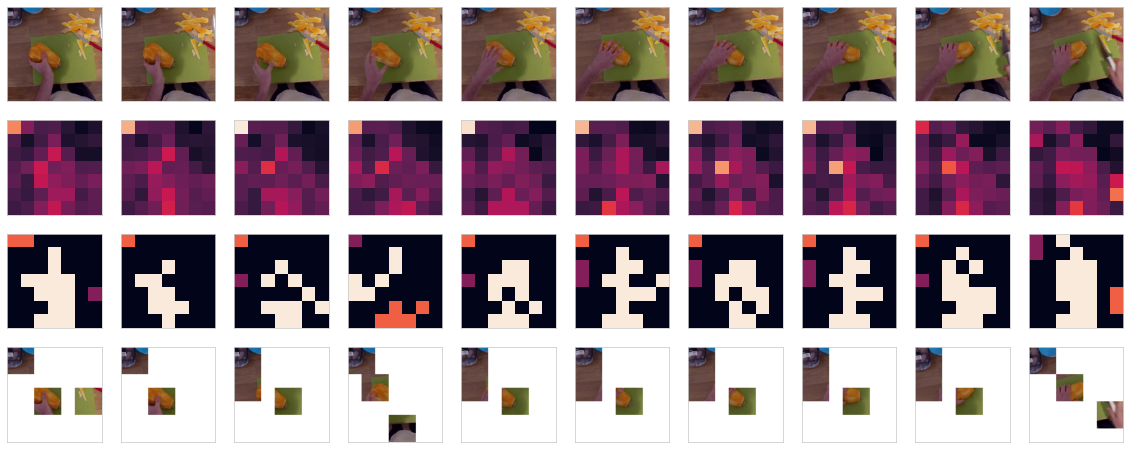

In [4]:
sample_id = 66
img_size = 224

with torch.no_grad():
    # Get a sample
    sample, _ = val_loader.dataset[sample_id]
    sample = {k: v.unsqueeze(dim=0).to(device) for k, v in sample.items()}

    # Forward
    model(sample)

    # Extract intermediate data, replicate the sampling process
    attn = model._pivot_mod_fn.get_attention_weight(
        l_name=model.attention_layer[0],
        m_name=model.attention_layer[1],
        aggregated=True,
    )
    
    bboxes = model.spatial_sampler.sample_multiple_frames(
        attn.unsqueeze(dim=0), img_size, reorder=True, avg_across_time=True)
    
    # Wrapper
    wrapper_bboxes, masks = sample_multiple_frames(attn.unsqueeze(dim=0), img_size, reorder=True)
    masks = masks.squeeze()
        
    assert np.all(bboxes == wrapper_bboxes)
    
    
rgb = MiscUtils.deprocess_rgb(sample['RGB'][0], model.num_segments)
vmin = attn.mean(dim=1).min()
vmax = attn.mean(dim=1).max()
attn = attn.cpu().detach().numpy()

fig, axes = plt.subplots(4, model.num_segments, figsize=(20, 8))
for t in range(model.num_segments):
    axes[0, t].imshow(rgb[t])
    axes[1, t].imshow(attn.mean(axis=1)[t], vmin=vmin, vmax=vmax)
    axes[2, t].imshow(masks[t])

    tmp = np.zeros_like(rgb[t]) + 255
    for k in range(model.spatial_sampler.top_k):
        top = bboxes[0, t, k, 0]
        left = bboxes[0, t, k, 1]
        bottom = bboxes[0, t, k, 2]
        right = bboxes[0, t, k, 3]
        tmp[top:bottom, left:right] = rgb[t, top:bottom, left:right]
    axes[3, t].imshow(tmp)
    
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

layer0 0 torch.Size([10, 2, 56, 56])
layer0 1 torch.Size([10, 2, 56, 56])
layer0 2 torch.Size([10, 2, 56, 56])
layer1 0 torch.Size([10, 8, 28, 28])
layer1 1 torch.Size([10, 8, 28, 28])
layer1 2 torch.Size([10, 8, 28, 28])
layer2 0 torch.Size([10, 16, 14, 14])
layer2 1 torch.Size([10, 16, 14, 14])
layer2 2 torch.Size([10, 16, 14, 14])
layer2 3 torch.Size([10, 16, 14, 14])
layer3 0 torch.Size([10, 32, 7, 7])
layer3 1 torch.Size([10, 32, 7, 7])
layer3 2 torch.Size([10, 32, 7, 7])
layer3 3 torch.Size([10, 32, 7, 7])
layer3 4 torch.Size([10, 32, 7, 7])
layer3 5 torch.Size([10, 32, 7, 7])
layer4 0 torch.Size([10, 64, 3, 3])
layer4 1 torch.Size([10, 64, 3, 3])
layer4 2 torch.Size([10, 64, 3, 3])


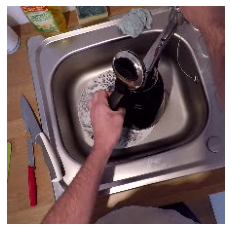

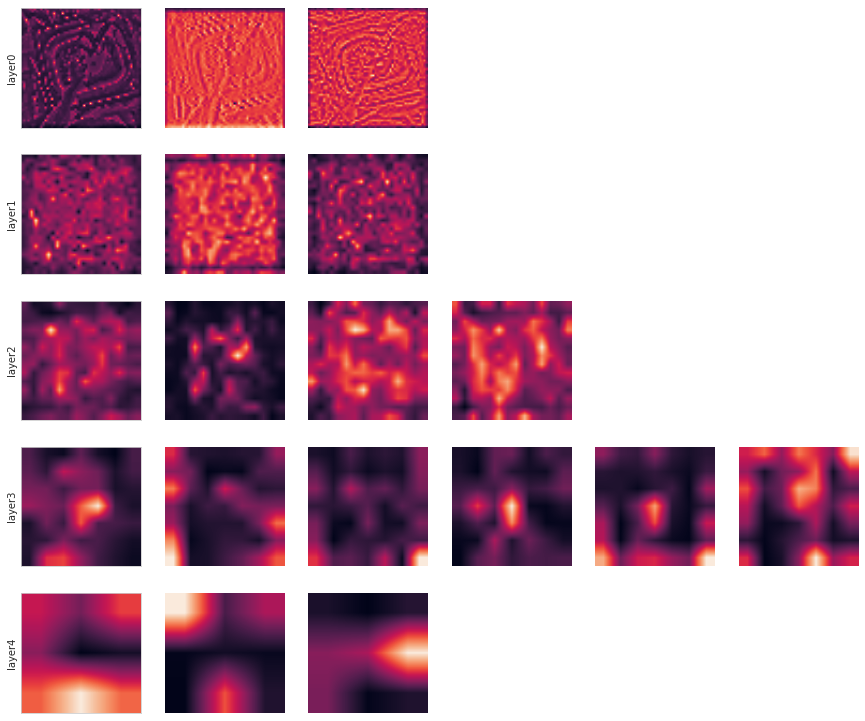

In [5]:
sample_id = 80
t_id = 0

with torch.no_grad():
    # Get a sample
    sample, _ = val_loader.dataset[sample_id]
    sample = {k: v.unsqueeze(dim=0).to(device) for k, v in sample.items()}

    # Forward
    model(sample)

rgb = MiscUtils.deprocess_rgb(sample['RGB'][0], model.num_segments)
fig, ax = plt.subplots(1, 1)
ax.axis('off')
ax.imshow(rgb[t_id])

attn_dict = model._pivot_mod_fn.get_all_attention_weights(aggregated=True)
fig, axes = plt.subplots(5, 6, figsize=(15, 13))
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    
for i, l in enumerate(attn_dict):
    axes[i, 0].set_ylabel(l)
    axes[i, 0].axis('on')
    for j, m in enumerate(attn_dict[l]):
        print(l, m, attn_dict[l][m].shape)
        axes[i, j].imshow(attn_dict[l][m].mean(dim=1)[t_id].cpu().detach().numpy(),
                          interpolation='bilinear')